# Определение токсичных комментариев

**Описание проекта:** Обучить модель классифицировать комментарии на позитивные и негативные. Значение метрики качества *F1* должно быть не меньше 0.75.

Дан набор данных с разметкой о токсичности правок.

In [2]:
import numpy as np
import pandas as pd
import warnings
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display_html

# подготовка, обучение и проверка качества модели
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

# работа с текстами
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#nltk.download('wordnet')
#nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

warnings.filterwarnings('ignore')

tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

# 1. Подготовка

In [4]:
data = pd.read_csv("/datasets/toxic_comments.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В датасете 159571 объектов и два признака - один текстового типа, второй числового. Ознакомимся с данными.

In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Первый признак 'text' содержит "сырые" тексты на английском языке. В текстах есть символы форматирования (например, обозначение переноса строки \n), слова в разных регистрах. Признак 'toxic' целевой, похоже что бинарный. Изучим баланс классов в выборке.

In [7]:
data['toxic'].value_counts() / len(data['toxic'])

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Видим, что в признаке всего два класса, значит будем решать задачу бнарной классификации. Токсичных комментариев в выборке мало - всего 10%, а значит имеет место дисбаланс классов. Есть несколько методов борьбы с дисбалансом. Например, некоторые модели могут самостоятельно перераспределять веса если это указать при настройке модели. Помимо этого можно провести апсемплинг/даунсемплинг выборки таким образом, чтобы снизить влияние дисбаланса на качество модели. Выбирать наиболее предпочтительный метод будем опираясь на ```confusion_matrix```, так как для нас важнее снизить количество ошибок при определении редкого класса.

Разделим признаки на обучающий и целевой. 

In [8]:
features = data['text']
target = data['toxic']

Теперь займемся подготовкой признаков. Для начала попробуем преобразование через лемматизацию и вычисление TF-IDF. Для лемматизации английских текстов воспользуемся библиотекой ```nltk```. Сначала очистим тексты от символов, использовав регулярные выражения, и приведем их к одному регистру, а затем лемматизируем.

In [9]:
def cleared_text(text):
    return " ".join(re.sub(r'[^a-zA-Z\']', ' ', text).split())

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    clear_text = cleared_text(text).lower()
    lemm_text = " ".join([lemmatizer.lemmatize(x, get_wordnet_pos(x)) for x in nltk.word_tokenize(clear_text)])
    return lemm_text

Сохраним результат отдельным фаилом, так как лемматизация занимает немало времени и это может помешать при проверке. 

In [12]:
# features = [lemmatize(x) for x in tqdm(features)]

In [13]:
# pd.DataFrame(data={'text': features}, index=data.index).to_csv("lemm_features.csv", index=False)

In [14]:
lemm_features = pd.read_csv("lemm_features.csv")

In [15]:
lemm_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 1 columns):
text    159565 non-null object
dtypes: object(1)
memory usage: 1.2+ MB


Возможно некоторые сообщения содержали в себе только символы, поэтому в данных появились пропуски. Удалим их.

In [16]:
lemm_features.dropna(inplace=True)

Отфильтруем таргеты по индексам. 

In [17]:
target = target.iloc[lemm_features.index]

Сравним текст до лемматизации и после.

In [18]:
display_side_by_side(data[['text']].head(), lemm_features.head())

,text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """
4,"You, sir, are my hero. Any chance you remember what page that's on?"
,text
0,explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalism just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retire now
1,d'aww he match this background colour i 'm seemingly stuck with thanks talk january utc
2,hey man i 'm really not try to edit war it 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info
3,more i ca n't make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it 's list in the relevant form eg wikipedia good article nomination transport


Видим, что тексты приведены к одному регистру, лишние символы исключены, слова приведены к базовой форме (например, множественное число к единственному, глаголы к начальной форме). Теперь разделим искомый датасет на две выборки - обучающую и тестовую, в пропорции 3:1. 

In [19]:
features_train, features_test, target_train, target_test = train_test_split(lemm_features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            stratify=target,
                                                                            random_state=88)

Следующим шагом вычислим TF-IDF для полученных текстов. Не будем учитывать стоп-слова.

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words, min_df=0.001)

In [22]:
tf_idf_train = count_tf_idf.fit_transform(features_train['text'])

In [23]:
tf_idf_test = count_tf_idf.transform(features_test['text'])

In [24]:
print("Размер обучающей матрицы признаков: ", tf_idf_train.shape)
print("Размер тестовой матрицы признаков: ", tf_idf_test.shape)

Размер обучающей матрицы признаков:  (119673, 3046)
Размер тестовой матрицы признаков:  (39892, 3046)


Признаки подготовлены, выборки поделены. Приступим к обучению. 

# 2. Обучение

#### LogisticRegression

In [25]:
penalty = ["l2", "l1"]
C = np.logspace(-1., 1, num=4)
solver = ["liblinear"]
warm_start = [True, False]
l1_ratio = [None, 0.3, 0.5, 0.7]
class_weight = [None, "balanced"]

log_grid = {'penalty': penalty,
            'C': C,
            'solver': solver,
            'warm_start': warm_start,
            'l1_ratio': l1_ratio,
            'class_weight': class_weight}

print(log_grid)

{'penalty': ['l2', 'l1'], 'C': array([ 0.1       ,  0.46415888,  2.15443469, 10.        ]), 'solver': ['liblinear'], 'warm_start': [True, False], 'l1_ratio': [None, 0.3, 0.5, 0.7], 'class_weight': [None, 'balanced']}


Подбор гиперпараметров с кросс-валидацией закомментирован, чтобы сократить время загрузки проекта на ревью. 

In [26]:
# log_test = LogisticRegression()

In [27]:
# log_random = RandomizedSearchCV(estimator=log_test, scoring="f1",
#     param_distributions=log_grid, verbose=2, refit="f1",
#     cv=5, random_state=357, n_jobs=-1)

# log_random.fit(tf_idf_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786, total=   1.0s
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786, total=   1.0s
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786 
[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786, total=   1.0s
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786 
[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786, total=   0.9s
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786 
[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.46415888336127786, total=   0.9s
[CV] warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=None, C=0.1 
[CV]  warm_start=False, solver=liblinear, penalty=l2, l1_ratio=0.7, class_weight=Non

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.46415888,  2.15443469, 10.        ]),
                                        'class_weight': [None, 'balanced'],
                                        'l1_ratio': [None, 0.3, 0.5, 0.7],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['liblinear'],
                                        'warm_start': [True, False]},
                   random_state=357, refit='f1', scoring='f1', verbose=2)

In [51]:
log_random_best_score = 0.757

print("F1 лучшей модели при валидации: ", log_random_best_score)

F1 лучшей модели при валидации:  0.757


In [52]:
log_best_params = {
    'warm_start': False,
    'solver': 'liblinear',
    'penalty': 'l1',
    'l1_ratio': 0.3,
    'class_weight': None,
    'C': 2.1544346900318834
}

log_best_params

{'warm_start': False,
 'solver': 'liblinear',
 'penalty': 'l1',
 'l1_ratio': 0.3,
 'class_weight': None,
 'C': 2.1544346900318834}

In [30]:
log_model = LogisticRegression(**log_best_params, random_state=248)

In [53]:
%%time

log_model.fit(tf_idf_train, target_train)

CPU times: user 2.1 s, sys: 44 ms, total: 2.14 s
Wall time: 2.15 s


LogisticRegression(C=2.1544346900318834, l1_ratio=0.3, penalty='l1',
                   random_state=248, solver='liblinear')

In [32]:
log_pred = log_model.predict(tf_idf_test)

In [33]:
print("F1 на обучающей выборке: ", log_model.score(tf_idf_train, target_train))
print("F1 на тестовой выборке: ", f1_score(log_pred, target_test))

F1 на обучающей выборке:  0.9605759026681039
F1 на тестовой выборке:  0.75120022592488


Разница в качестве обучающей и тестовой выборке около 0.2, что немало. Посмотрим как распределились ошибки по классам.

In [34]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Target')
    plt.xlabel('Predicted')

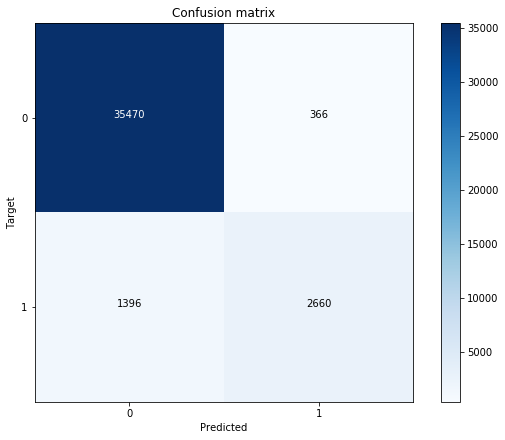

In [35]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, log_pred)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Ошибки распределились удовлетворительно - большинство объектов редкого класса определились верно. Качество модели на тестовой выборке 0.75, что по условию задачи соответствует минимальному допустимому порогу.

Попробуем решить проблему дисбаланса классов посредством проведения апсемплинга и даунсемплинга. Может быть это поможет улучшить качество модели.

#### Апсемплинг:

In [36]:
%%time

oversample_pipeline = make_pipeline(RandomOverSampler(random_state=123), 
                                    LogisticRegression(**log_best_params))

log_oversample_score = cross_val_score(oversample_pipeline, tf_idf_train,
                                       target_train, scoring='f1', cv=5)

print("F1 лучшей модели при валидации: ", log_oversample_score.max())

F1 лучшей модели при валидации:  0.6696340257171117
CPU times: user 13.3 s, sys: 456 ms, total: 13.8 s
Wall time: 14.1 s


#### Даунсемплинг:

In [37]:
%%time

undersample_pipeline = make_pipeline(RandomUnderSampler(random_state=321), 
                                     LogisticRegression(**log_best_params))

log_undersample_score = cross_val_score(undersample_pipeline, tf_idf_train,
                                        target_train, scoring='f1', cv=5)

print("F1 лучшей модели при валидации: ", log_undersample_score.max())

F1 лучшей модели при валидации:  0.6726238830219333
CPU times: user 1.15 s, sys: 12 ms, total: 1.16 s
Wall time: 1.18 s


Улучшить качество модели за счет апсемплинга и даунсемплинга не удалось. Пока лучший результат у первой обученной модели логистической регрессии и он равен 0.75. Попробуем обучить еще одну модель. 

### SGDClassifier

In [38]:
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive',
        'hinge', 'modified_huber', 'squared_hinge', 'perceptron']
penalty = ['l2', 'l1', 'elasticnet']
alpha = [0.0001, 0.005, 0.01]
l1_ratio = [0.0, 0.15, 0.3]
fit_intercept = [True, False]
shuffle = [True, False]
class_weight = ['balanced', None]
warm_start = [True, False]

sgdc_grid = {'loss': loss,
             'penalty': penalty,
             'alpha': alpha,
             'l1_ratio': l1_ratio,
             'fit_intercept': fit_intercept,
             'shuffle': shuffle,
             'class_weight': class_weight,
             'warm_start' : warm_start
            }

print(sgdc_grid)

{'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.01], 'l1_ratio': [0.0, 0.15, 0.3], 'fit_intercept': [True, False], 'shuffle': [True, False], 'class_weight': ['balanced', None], 'warm_start': [True, False]}


Процесс подбора гиперпараметров закомментирован, чтобы сократить время загрузки проекта на ревью.

In [39]:
# sgdc_test = SGDClassifier()

In [40]:
# sgdc_random = RandomizedSearchCV(estimator=sgdc_test, scoring="f1",
#     param_distributions=sgdc_grid, verbose=2, refit="f1",
#     random_state=654, n_jobs=-1)

# sgdc_random.fit(tf_idf_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01, total=   0.2s
[CV] warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01, total=   0.2s
[CV] warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01 
[CV]  warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01, total=   0.2s
[CV] warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01 
[CV]  warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01, total=   0.2s
[CV] warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class_weight=None, alpha=0.01 
[CV]  warm_start=True, shuffle=True, penalty=l2, loss=epsilon_insensitive, l1_ratio=0.15, fit_intercept=True, class

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(estimator=SGDClassifier(), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.005, 0.01],
                                        'class_weight': ['balanced', None],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0.0, 0.15, 0.3],
                                        'loss': ['squared_loss', 'huber',
                                                 'epsilon_insensitive',
                                                 'squared_epsilon_insensitive',
                                                 'hinge', 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'shuffle': [True, False],
                                        'warm_start': [True, False]},
      

In [41]:
sgdc_random_best_score = 0.655

print("F1 лучшей модели при валидации: ", sgdc_random_best_score)

F1 лучшей модели при валидации:  0.655


In [42]:
sgdc_best_params = {
    'warm_start': False,
    'shuffle': False,
    'penalty': 'l2',
    'loss': 'epsilon_insensitive',
    'l1_ratio': 0.0,
    'fit_intercept': True,
    'class_weight': 'balanced',
    'alpha': 0.005
}

sgdc_best_params

{'warm_start': False,
 'shuffle': False,
 'penalty': 'l2',
 'loss': 'epsilon_insensitive',
 'l1_ratio': 0.0,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'alpha': 0.005}

In [43]:
sgdc = SGDClassifier(**sgdc_best_params)

In [44]:
%%time

sgdc.fit(tf_idf_train, target_train)

CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 170 ms


SGDClassifier(alpha=0.005, class_weight='balanced', l1_ratio=0.0,
              loss='epsilon_insensitive', shuffle=False)

In [45]:
sgdc_pred = sgdc.predict(tf_idf_test)

In [46]:
print("F1 на обучающей выборке: ", sgdc.score(tf_idf_train, target_train))
print("F1 на тестовой выборке: ", f1_score(sgdc_pred, target_test))

F1 на обучающей выборке:  0.9432286313537723
F1 на тестовой выборке:  0.655880149812734


Рассмотрим матрицу ошибок последней обученной модели.

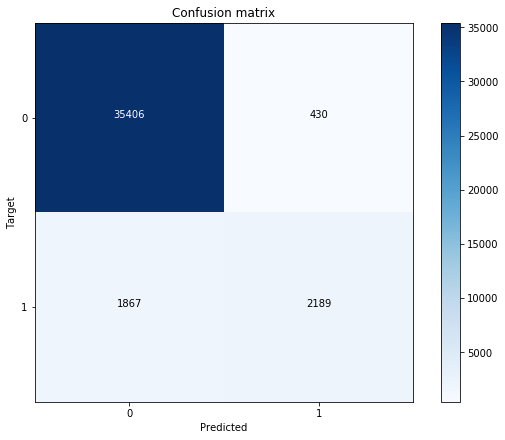

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, sgdc_pred)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

#### Апсемплинг

In [48]:
%%time

oversample_pipeline = make_pipeline(RandomOverSampler(random_state=123), 
                                    SGDClassifier(**sgdc_best_params))

sgdc_oversample_score = cross_val_score(oversample_pipeline, tf_idf_train,
                                        target_train, scoring='f1', cv=5)

print("F1 лучшей модели при валидации: ", sgdc_oversample_score.max())

F1 лучшей модели при валидации:  0.6895119418483905
CPU times: user 1.38 s, sys: 120 ms, total: 1.5 s
Wall time: 1.51 s


#### Даунсемплинг

In [49]:
%%time

undersample_pipeline = make_pipeline(RandomUnderSampler(random_state=321), 
                                     SGDClassifier(**sgdc_best_params))

sgdc_undersample_score = cross_val_score(undersample_pipeline, tf_idf_train,
                                        target_train, scoring='f1', cv=5)

print("F1 лучшей модели при валидации: ", sgdc_undersample_score.max())

F1 лучшей модели при валидации:  0.677872256278426
CPU times: user 390 ms, sys: 20 ms, total: 410 ms
Wall time: 420 ms


После проведения апсемплинга удалось немного улучшить качество модели до 0.68. Однако этого все равно мало, чтобы модель прошла по условию задачи.

Соберем результаты кросс-валидации в одну таблицу, чтобы было удобнее выбрать наилучшую модель.

In [54]:
result = pd.DataFrame(data={
    'Logistic Regression': log_random_best_score,
    'Logistic Regression (oversampling)': log_oversample_score.max(),
    'Logistic Regression (undersampling)': log_undersample_score.max(),
    'SGD Classifier': sgdc_random_best_score,
    'SGD Classifier (oversampling)': sgdc_oversample_score.max(),
    'SGD Classifier (undersampling)': sgdc_undersample_score.max()
}, index=["F1-value"]).round(2)

result

,Logistic Regression,Logistic Regression (oversampling),Logistic Regression (undersampling),SGD Classifier,SGD Classifier (oversampling),SGD Classifier (undersampling)
F1-value,0.76,0.67,0.67,0.66,0.69,0.68


# 3. Выводы

В рамках задачи было необходимо обучить модель для поиска и отправки на модерацию потенциально токсичных комментариев. Для этого сначала нужно было подготовить признаки в соответствии с выбранным способом обработки. В качестве способа обработки был выбрана оценка важности через вычисление величины TF-IDF. Перед векторизацией, тексты были очищены от лишних символов, приведены к одному регистру, токенизированы, лемматизированы.

После подготовки признаков было произведено обучение нескольких моделей классификации. При обучении был учтен дисбаланс классов — он был учтен как при настройке гиперпараметров, так и при помощи апсемплинга/даунсемплинга обучающей выборки. Модели сравнивались не только по величине F1-метрики, но также были сопоставлены их матрицы ошибок. В процессе сравнения было определено, что лучшей и наиболее гармоничной по F1-метрике и матрице ошибок получилась первая модель логистической регрессии (F1 = 0.76), а худшей — классификатор стохастического градиентного спуска (F1 = 0.66).

При проверке модели логистической регрессии на тестовой выборке удалось достичь минимально допустимого значения F1-меры (F1 = 0.75).